In [110]:
import glob
import os

from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstD,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Resized,
    ToTensord
)

from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism

from monai.utils import first
import matplotlib.pyplot as plt

In [116]:
def preprocess_data (input_directory, pixdim=(1.5, 1.5, 1.0), a_min = -200, a_max = 200, spatial_size = [128, 128, 30], cache=True):
    
    set_determinism(seed=0)

    train_volumes_path = sorted(glob.glob(os.path.join(input_directory, 'TrainImages', '*.nii.gz')))
    train_labels_path = sorted(glob.glob(os.path.join(input_directory, 'TrainLabels', '*.nii.gz')))

    test_volumes_path = sorted(glob.glob(os.path.join(input_directory, 'TestImages', '*.nii.gz')))
    test_labels_path = sorted(glob.glob(os.path.join(input_directory, 'TestLabels', '*.nii.gz')))

    train_files = [{'volume': volume_name, 'label': label_name} for volume_name, label_name in 
                   zip(train_volumes_path, train_labels_path)]
    test_files = [{'volume': volume_name, 'label': label_name} for volume_name, label_name in 
                   zip(test_volumes_path, test_labels_path)]
    
    train_data_transforms = Compose(
        [
            LoadImaged(keys=['volume', 'label']),
            EnsureChannelFirstD(keys=['volume', 'label']),
            Spacingd(keys=["volume", "label"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["volume", "label"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["volume"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            #CropForegroundd(keys=["volume", "label"], source_key="volume"),
            Resized(keys=["volume", "label"], spatial_size=spatial_size),
            ToTensord(keys=["volume", "label"]),
        ]
    )

    test_data_transforms = Compose(
        [
            LoadImaged(keys=["volume", "label"]),
            EnsureChannelFirstD(keys=["volume", "label"]),
            Spacingd(keys=["volume", "label"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["volume", "label"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["volume"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True),
            #CropForegroundd(keys=['volume', 'label'], source_key='volume'),
            Resized(keys=["volume", "label"], spatial_size=spatial_size),
            ToTensord(keys=["volume", "label"]),
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_data_transforms, cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = CacheDataset(data=test_files, transform=test_data_transforms, cache_rate=1.0)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_data_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        test_ds = Dataset(data=test_files, transform=test_data_transforms)
        test_loader = DataLoader(test_ds, batch_size=1)

        return train_loader, test_loader

In [119]:
def show_patient(data, SLICE_NUMBER=1, train=True, test=False):

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["volume"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["volume"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["label"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

c:\Users\Вадим\AppData\Local\Programs\Python\Python311\Lib\site-packages\monai\data\dataset.py:876: UserWarning: tqdm is not installed, will not show the caching progress bar.
  warnings.warn("tqdm is not installed, will not show the caching progress bar.")


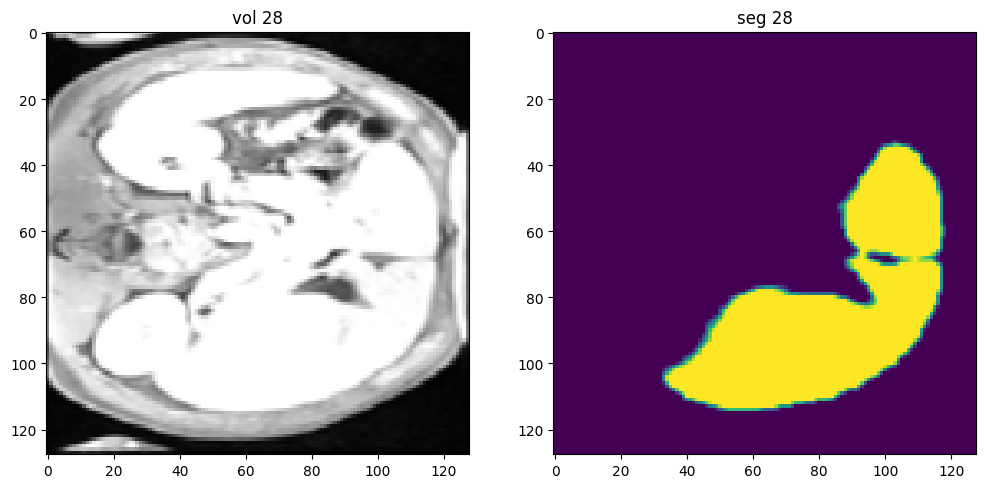

In [123]:
in_dir = 'D:/GraduateWorkData/nifti_files2'
patient = preprocess_data(in_dir)
show_patient(patient, SLICE_NUMBER=28)